In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sn
import random
from scipy import spatial
from collections import Counter
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
import spacy
# import gensim
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import chisquare, chi2_contingency
from rhc import mutual_info
from rhc import recursiveHierarchicalClustering

np.seterr(all='raise')

nlp = spacy.load('en_core_web_lg')
# lemmatizer = nlp.add_pipe('lemmatizer')
stopwords = nlp.Defaults.stop_words

# bc = BertClient(ip="internal.kixlab.org", port=8888, port_out=8889)


In [2]:
queries = pd.read_csv('new_logs.csv', index_col="idx", dtype={"AnonID": "Int64", "Query": "string", "QueryTime": "string", "ItemRank": "Int32", "ClickURL": "string", "Type": "string", "SessionNum": "Int32"}, keep_default_na=False, na_values=[""])

queries = queries.loc[queries['Query'] != '-']


In [3]:
group_by_sessions = queries.groupby('AnonID', sort=False, as_index=False)
qqq = group_by_sessions.max(numeric_only=True)
newIDs = qqq.loc[qqq['SessionNum'] >= 19]
# print(newIDs)
# print(newIDs["AnonID"])



In [4]:
def compute_edit_distance(queryA, queryB): # Character level
  a = len(queryA)
  b = len(queryB)
  dp = [[0 for x in range(b + 1)] for x in range(a + 1)]

  for i in range(a + 1):
    for j in range(b + 1):
      if i == 0:
        dp[i][j] = j
      elif j == 0:
        dp[i][j] = i
      elif queryA[i - 1] == queryB[j - 1]:
        dp[i][j] = dp[i-1][j-1]
      else:
        dp[i][j] = 1 + min(dp[i-1][j-1], dp[i][j-1], dp[i-1][j])

  return dp[a][b]

def compute_shared_words(queryA, queryB):
  setA = set(queryA)
  setB = set(queryB)

  union = setA.union(setB)
  intersect = setA.intersection(setB)
  try:
    return len(intersect) / len(union)
  except:
    print(queryA, queryB)
    return 0

def compute_semantic_similarity(old_query, new_query):
  # embeddings = bc.encode([old_query, new_query])
  # return 1 - spatial.distance.cosine(embeddings[0], embeddings[1])

  return 1

def is_new_query(old_query, old_processed_query, new_query, new_processed_query):
  # compute semantic similarities and edit distances to gauge query similarities
  if compute_edit_distance(old_query, new_query) < 3: #
    return False

  if compute_shared_words(old_processed_query, new_processed_query) > 0.7:
    return False

  # if old_processed_query.similarity(new_processed_query) > 0.8:
  #   return False
    
  return True

def process_query(query):
  doc = nlp(query)
  tokens_wo_sw = [word.lemma_ for word in doc if ((word.is_stop == False) and (word.is_punct == False) and word.lemma_ != '-PRON-')]
  return tokens_wo_sw

def flatten_logs(logs_dataframe):
  previous_row = None
  previous_query = ''
  previous_processed_query = None
  flattened = []
  
  for idx, row in logs_dataframe.iterrows():
    if previous_row is None: # Every logstream starts with a query
      # print(row)
      flattened.append("NewQuery")
      previous_row = row
      previous_query = row['Query']
      previous_processed_query = process_query(previous_query)
      
      continue

    if row["Type"] == "Query":
      new_processed_query = process_query(row['Query'])
      if is_new_query(previous_query, previous_processed_query, row['Query'], new_processed_query):
        flattened.append("NewQuery")
        previous_query = row['Query']
        previous_processed_query = new_processed_query
      else:
        flattened.append("RefinedQuery")
    elif row["Type"] == "Click":
      if row["ItemRank"] == 1:
        flattened.append("Click1")
      elif row["ItemRank"] >= 2 and row["ItemRank"] < 6:
        flattened.append("Click2-5")
      elif row["ItemRank"] >= 6 and row["ItemRank"] < 10:
        flattened.append("Click6-10")
      else:
        flattened.append("Click11+")
    elif row["Type"] == "NextPage":
      flattened.append("NextPage")

  return flattened


def create_n_gram(sequence, n):
  if n < 2:
    return []
  ngram = []
  length = len(sequence)
  if length < n:
    filled = sequence + ["Empty" for i in range(n - length)]
    ngram.append(tuple(filled))

  else:
    for i in range(length - n + 1):
      ngram.append(tuple(sequence[i:i+n]))

  return ngram + create_n_gram(sequence, n - 1)


def compute_distance(n_gram_1, n_gram_2, concatenated_set):
  counter_ngram_1 = Counter(n_gram_1)
  counter_ngram_2 = Counter(n_gram_2)


  n_gram_vec_1 = np.asarray([(counter_ngram_1[n]) for n in concatenated_set])
  n_gram_vec_1 = n_gram_vec_1 / np.linalg.norm(n_gram_vec_1)
  n_gram_vec_2 = np.asarray([(counter_ngram_2[n]) for n in concatenated_set])
  n_gram_vec_2 = n_gram_vec_2 / np.linalg.norm(n_gram_vec_2)

  distance = np.arccos((np.dot(n_gram_vec_1, n_gram_vec_2) / np.sqrt(np.dot(n_gram_vec_1, n_gram_vec_1) * np.dot(n_gram_vec_2, n_gram_vec_2)))) / np.pi

  return distance

def ngrams_to_vectors(n_gram_1, concatenated_set):
  counter_ngram_1 = Counter(n_gram_1)
  n_gram_vec_1 = np.asarray([(counter_ngram_1[n]) for n in concatenated_set])
  # n_gram_vec_1 = n_gram_vec_1 / np.linalg.norm(n_gram_vec_1)

  return n_gram_vec_1


def generate_sequences_and_n_grams(group_by_sessions, sample, n = 5):
  sequences = []
  ngrams = []

  for s in sample:
    g = group_by_sessions.get_group(s)
    flattened_log = flatten_logs(g)
    ngram = create_n_gram(flattened_log, n)
    sequences.append(flattened_log)
    ngrams.append(ngram)

  concat_set = list(set([ngram for n in ngrams for ngram in n]))

  return sequences, ngrams, concat_set

def generate_n_grams(sequences, n = 5):
  ngrams = [create_n_gram(seq, n) for seq in sequences]

  concat_set = list(set([ngram for n in ngrams for ngram in n]))

  return ngrams, concat_set



In [5]:
group_by_sessions = queries.groupby(["AnonID", "SessionNum"])

tuples = []
# for idx, row in newIDs.iterrows():
#   tuples += [(row["AnonID"], i) for i in range(row["SessionNum"])]

## First, extract all tuples with appropriately long sessions

ssss = group_by_sessions.count()
ss = ssss[ssss["Query"] >= 5]

for idx, _ in ss.iterrows():
  tuples += [idx]

### Then, draw 5,000 samples


In [7]:

SAMPLE_SIZE = 5000

random.seed(0)

sample = random.sample(tuples, SAMPLE_SIZE)

sequences = []

for s in sample:
  g = group_by_sessions.get_group(s)
  flattened_log = flatten_logs(g)
  sequences.append(flattened_log)

# sequences, ngrams, concat_set = generate_sequences_and_n_grams(group_by_sessions, sample, n = 5)

[] []


In [15]:
def getHalfPoint(scores):
	values = [x[1] for x in scores]
	total = sum(values) * 3 / 4
	cur = 0
	idx = 0
	for (idx, score, featureNum) in scores:
		cur += score
		if cur > total:
			break
	# print('half point stats', idx, min(values), max(values))
	return idx

def getSweetSpotL(evalResults):
	if len(evalResults) == 0: return 0
	cutoff = currentKnee = evalResults[-1][0]
	# print(evalResults)
	lastKnee = currentKnee + 1

	while currentKnee < lastKnee:
		lastKnee = currentKnee
		currentKnee = LMethod([item for item in evalResults if item[0] <= cutoff])
		# print(currentKnee)
		cutoff = currentKnee * 2

	return currentKnee

# tool used for finding out the defining feature threshold
# performs linear regression
def linearReg(evalResults):
	x = np.array([xv for (xv,yv, featureNum) in evalResults])
	y = np.array([yv for (xv,yv, featureNum) in evalResults])
	# print(x, y)
	A = np.vstack([x, np.ones(len(x))]).T
	result = np.linalg.lstsq(A,y)
	m, c = result[0]
	residual = result[1]
	# print(result)
	return ((m, c), residual if len(evalResults) > 2 else 0)

# using the L-Method, find of the sweetspot for getting defining features
def LMethod(evalResults):
	# print(len(evalResults))
	if len(evalResults) < 4:
		return len(evalResults)
	# the partition point c goes from the second point to the -3'th point
	minResidual = np.inf
	minCons = None
	minCutoff = None
	for cidx in range(1, len(evalResults) - 2):
		(con1, residual1) = linearReg(evalResults[:cidx + 1])
		(con2, residual2) = linearReg(evalResults[cidx + 1:])
		if (residual1 + residual2) < minResidual:
			minCons = (con1, con2)
			minCutoff = cidx
			minResidual = residual1 + residual2
	if minCutoff == None:
		print(('minCutoff is None', evalResults))
	return evalResults[minCutoff][0]

In [18]:
def modularity(clusters, distances, m):
  num_clusters = len(clusters)
  print(clusters)

  e_matrix = np.zeros((num_clusters, num_clusters))
  for i in range(len(clusters)):
    for j in range(i):
      selected_matrix = 1 - distances[np.ix_(clusters[i], clusters[j])]
      e_matrix[i, j] = np.sum(selected_matrix) / (m)
      if i == j:
        e_matrix[i, j] = e_matrix[i, j] / 2
      e_matrix[j, i] = e_matrix[i, j]

  modularity = np.trace(e_matrix) - np.sum(e_matrix * e_matrix)

  print(e_matrix)

  return modularity

  



def normalize_vectors(vectors):
  average_vector = np.average(vectors, axis=0)
  normalized_vectors = vectors #  - average_vector

  normalized_vectors = normalize(normalized_vectors, axis = 1)

  return normalized_vectors

def compute_polar_distance(n_gram_vec_1, n_gram_vec_2):
  distance = np.arccos(1 - spatial.distance.cosine(n_gram_vec_1, n_gram_vec_2)) / np.pi #np.arccos((np.dot(n_gram_vec_1, n_gram_vec_2) / np.sqrt(np.dot(n_gram_vec_1, n_gram_vec_1) * np.dot(n_gram_vec_2, n_gram_vec_2)))) / np.pi
  return distance


def divisive_clustering(ngrams, concat_set, n_clusters):
  vectors = np.asarray([ngrams_to_vectors(ngram, concatenated_set=concat_set) for ngram in ngrams])

  clusters = np.asarray([1 for vector in vectors])

  distinguishing_features = {1: []}

  len_vectors = len(vectors)

  whole_distances = np.zeros((len_vectors, len_vectors))


  MIN_CLUSTER_SIZE = 100



  for i in range(len_vectors):
    for j in range(i+1):
      whole_distances[i, j] = compute_polar_distance(vectors[i], vectors[j]) #compute_distance(ngrams[i], ngrams[j], concatenated_set=concat_set)
      whole_distances[j, i] = whole_distances[i, j]

    clusters_info = {
      1: {
        "type": 'Tree',
        "cluster_size": len(vectors),
        "diameter": np.max(whole_distances),
        "children": None
      }
    }
  m = np.sum(whole_distances)

  print("m: %f" % m)

  for i in range(n_clusters):
    print('%dth division' % (i))

    idx = -1
    max_cluster_size = 0
    max_diameter = 0
    for key, cluster in clusters_info.items():
      # if cluster["diameter"] < 0.05:
      #   cluster["type"] = 'Leaf'
      if cluster["cluster_size"] < MIN_CLUSTER_SIZE:
        cluster["type"] = 'Leaf'
      if cluster["cluster_size"] > max_cluster_size and cluster["type"] == 'Tree' and cluster["children"] is None:
        idx = key    
        max_cluster_size = cluster["cluster_size"]
        max_diameter = cluster["diameter"]

    if idx == -1:
      break
    
    divide(vectors, clusters, distinguishing_features, clusters_info, idx, whole_distances)
    score = silhouette_score(vectors, clusters, metric='cosine')

    mod_clusters = [np.where(clusters == i)[0] for i in np.unique(clusters)]
    modularity_score = modularity(mod_clusters, whole_distances, m)

    print("Modularity score at iteration %d: %f" % (i, modularity_score))
    print("Silhouette_score at iteration %d: %f" % (i, score))

  return clusters, distinguishing_features, vectors, clusters_info

def divide(vectors, clusters, distinguishing_features, clusters_info, cluster_id, whole_distances):

  print('Dividing cluster %d' % cluster_id)
  selected_vector_idx = np.where(clusters == cluster_id)[0]
  # print(selected_vector_idx)
  selected_vector_size = len(selected_vector_idx)
  selected_vectors = vectors[selected_vector_idx].copy()
  selected_vectors[:, distinguishing_features[cluster_id]] = 0
  # print(distinguishing_features[cluster_id])

  distances = np.zeros((selected_vector_size, selected_vector_size))

  if cluster_id == 1:
    distances = whole_distances
  else:

    # print(distances.size)

    # normalized_vectors = normalize_vectors(selected_vectors)

    for i in range(selected_vector_size):
      for j in range(i+1):
        try:
          if np.any(selected_vectors[i]) == False or np.any(selected_vectors[j]) == False:
            distances[i, j] = 0
            distances[j, i] = 0
            continue
          distances[i, j] = compute_polar_distance(selected_vectors[i], selected_vectors[j]) #compute_distance(ngrams[i], ngrams[j], concatenated_set=concat_set)
          distances[j, i] = distances[i, j]
        except:
          print(sequences[i], sequences[j])
          print(vectors[i], vectors[j])
          print(selected_vectors[i], selected_vectors[j])
          print([concat_set_dict[n][idx] for idx in distinguishing_features[cluster_id]])


  # splinters = [np.argmax(np.sum(distances, axis = 0))]

  mask = np.ones(selected_vector_size, bool)

  mask[np.argmax(np.average(distances, axis = 1))] = False
  # print(np.argmax(np.average(distances, axis = 1)))
  while True:
    avg_distance_to_splinters = np.average(distances[:, ~mask], axis=1)

    avg_distance_within = np.average(distances[:, mask], axis=1)

    diff = avg_distance_to_splinters - avg_distance_within

    diff[~mask] = np.Inf
    candidate = np.argmin(diff)
    # print(candidate, diff[candidate], mask[candidate])

    if diff[candidate] < 0:
      mask[candidate] = False
    else:
      break

  # splinter_cluster = selected_vectors[~mask]
  # remaining_cluster = selected_vectors[mask]

  in_cluster_id = max(clusters_info.keys()) + 1
  out_cluster_id = max(clusters_info.keys()) + 2

  clusters_info[cluster_id]["children"] = [in_cluster_id, out_cluster_id]

  in_clusters = selected_vector_idx[~mask]
  out_clusters = selected_vector_idx[mask]

  clusters[in_clusters] = in_cluster_id
  clusters[out_clusters] = out_cluster_id

  # contingency_table = np.asarray([np.sum(splinter_cluster, axis=0), np.sum(remaining_cluster, axis=0)])

  max_chisq = 0
  max_idx = 0
  chisqs = []
  for i in range(vectors.shape[1]):
    if i in distinguishing_features[cluster_id]:
      continue
    splinter_cluster_dist = vectors[in_clusters, i]
    remaining_cluster_dist = vectors[out_clusters, i]
    chi2 = mutual_info.chi_square(remaining_cluster_dist, 0, splinter_cluster_dist, 0)
    # cont = np.asarray([[np.where(splinter_cluster[:, i] > 0)[0].size, np.where(splinter_cluster[:, i] <= 0)[0].size],
    # [np.where(remaining_cluster[:, i] > 0)[0].size, np.where(remaining_cluster[:, i] <= 0)[0].size]])
    # if not np.all(cont):
    #   continue
    # # print(cont)
    # chi2, p, dof, ex = chi2_contingency(cont)
    # print("Chi sq for cluster %d, component %d: %d" % (cluster_id, i, chi2))
    chisqs.append((i, chi2))
    if chi2 > max_chisq:
      max_chisq = chi2
      max_idx = i
  chisqs = sorted(chisqs, key= lambda x: x[1], reverse = True)
  chisqs = [(idx, score[1], score[0]) for idx, score in enumerate(chisqs)]
  # print(chisqs)
  halfpoint = getHalfPoint(chisqs)
  res = getSweetSpotL(chisqs[:max(200, 2 * halfpoint)])
  print('Initial res: %d' % res)
  if res > 10:
    res = 10
  cutoff_features = [x[0] for x in chisqs[:(res+1)]]
  # print(chisqs, res, cutoff_features)
  # cutoff_point = next(i for i,v in enumerate(chisqs) if v[0] == res)
  # cutoff_features = [x[0] for x in chisqs[:cutoff_point]]
  # print(chisqs)
  # print(res)
  # print(cutoff_features)

  distinguishing_features[in_cluster_id] = distinguishing_features[cluster_id] + cutoff_features
  distinguishing_features[out_cluster_id] = distinguishing_features[cluster_id]

  in_cluster_dist = whole_distances[np.ix_(in_clusters, in_clusters)]
  out_cluster_dist = whole_distances[np.ix_(out_clusters, out_clusters)]


  clusters_info[in_cluster_id] = {
    "type": 'Tree',
    "cluster_size": in_clusters.shape[0],
    "diameter": np.max(in_cluster_dist),
    "children": None
  }


  clusters_info[out_cluster_id] = {
    "type": 'Tree',
    "cluster_size": out_clusters.shape[0],
    "diameter": np.max(out_cluster_dist),
    "children": None
  }


# Measuring modularity?




In [9]:
seq_dict = {}
ngram_dict = {}
concat_set_dict = {}
clusters_dict = {}
distinguishing_features_dict = {}
vectors_dict = {}
clusters_info_dict = {}


In [19]:

for n in range(5, 6):
  ngram_dict[n], concat_set_dict[n] = generate_n_grams(sequences, n = n)
  clusters_dict[n], distinguishing_features_dict[n], vectors_dict[n], clusters_info_dict[n] = divisive_clustering(ngram_dict[n], concat_set_dict[n], 10)
  score = silhouette_score(vectors_dict[n], clusters_dict[n], metric='cosine')
  print("n-gram size: %f, silhouette score: %f" % (n, score))


m: 11481365.972030
0th division
Dividing cluster 1
[(0, 52596.75005339381, 3281), (1, 49865.706146477656, 6148), (2, 36953.33522473773, 6387), (3, 15761.225917572498, 7394), (4, 12472.190167904528, 3667), (5, 12012.473245592222, 3180), (6, 11988.501566513889, 1964), (7, 10960.247230882083, 7411), (8, 10754.043532070082, 6006), (9, 10322.669163594996, 2766), (10, 9608.926283671875, 3523), (11, 9402.265062130959, 7560), (12, 8678.692203479137, 889), (13, 7803.937642977477, 750), (14, 6345.108576002798, 2903), (15, 6160.016151896674, 1808), (16, 6071.177433820611, 4147), (17, 5954.655410017077, 3989), (18, 5558.58845581001, 3138), (19, 5278.289601351818, 3677), (20, 3878.9325745041465, 3313), (21, 3029.0188886851274, 5085), (22, 2914.008110361934, 3878), (23, 2751.3331554549286, 356), (24, 2307.693994528412, 4855), (25, 1709.8074863926297, 1345), (26, 1525.6809300418304, 6988), (27, 1515.3212008875594, 1209), (28, 1498.3175994091096, 366), (29, 1288.5447526580856, 1591), (30, 1184.4140460

/var/folders/8k/n5c708p107zcftdwsvs9d3140000gn/T/ipykernel_44344/3896191316.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


[array([   3,    4,    5, ..., 4995, 4997, 4998]), array([   0,    1,    2, ..., 4994, 4996, 4999])]
[[0.         0.24321488]
 [0.24321488 0.        ]]
Modularity score at iteration 0: -0.118307
Silhouette_score at iteration 0: 0.112373
1th division
Dividing cluster 3
[(0, 14232.254540107102, 6318), (1, 12056.631921838842, 4495), (2, 2896.5664100946033, 1209), (3, 2724.280214306287, 182), (4, 2274.766655285941, 5230), (5, 2224.729030796836, 4866), (6, 2035.5646009087923, 7343), (7, 1395.8252000898426, 7546), (8, 1270.8389931344843, 3132), (9, 1190.003429988098, 3879), (10, 1188.8899876166258, 3882), (11, 932.0907717691196, 342), (12, 792.820684253268, 2957), (13, 779.4945919370095, 1226), (14, 754.2049429635483, 7662), (15, 750.5063954659917, 4178), (16, 681.2300596481609, 2200), (17, 578.5439732431337, 6363), (18, 492.9598902387006, 4302), (19, 473.2213075060533, 7782), (20, 451.3822439542211, 3072), (21, 399.18386128091134, 2254), (22, 382.66312868426854, 7478), (23, 369.748808238378

/var/folders/8k/n5c708p107zcftdwsvs9d3140000gn/T/ipykernel_44344/3896191316.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


[array([   3,    4,    5, ..., 4995, 4997, 4998]), array([   0,   11,   22, ..., 4990, 4991, 4996]), array([   1,    2,    8, ..., 4993, 4994, 4999])]
[[0.         0.10481918 0.1383957 ]
 [0.10481918 0.         0.13623414]
 [0.1383957  0.13623414 0.        ]]
Modularity score at iteration 1: -0.097400
Silhouette_score at iteration 1: 0.097860
2th division
Dividing cluster 5
[(0, 4908.65797307373, 2032), (1, 4070.820811800172, 3011), (2, 2951.9649838833775, 1036), (3, 2864.765727181278, 469), (4, 2781.023189676407, 7455), (5, 2705.359435013477, 4010), (6, 2443.5957217556343, 1209), (7, 2251.78265503876, 7905), (8, 2194.8746343273383, 6781), (9, 1757.7436098541984, 2703), (10, 1691.8444155252046, 6363), (11, 1590.1993384505633, 1450), (12, 1509.5834342547012, 7047), (13, 1359.6427823098124, 7468), (14, 1284.984652303925, 6444), (15, 1176.4522474276862, 476), (16, 990.9549077944091, 3580), (17, 954.1481112665113, 6302), (18, 907.8774787362353, 3072), (19, 897.2210558069382, 3962), (20, 76

/var/folders/8k/n5c708p107zcftdwsvs9d3140000gn/T/ipykernel_44344/3896191316.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


[array([   3,    4,    5, ..., 4995, 4997, 4998]), array([   0,   11,   22, ..., 4990, 4991, 4996]), array([  32,   33,   38,   61,   71,  110,  119,  120,  132,  133,  158,
        160,  187,  197,  218,  219,  221,  230,  242,  243,  247,  250,
        253,  263,  273,  276,  278,  287,  304,  314,  320,  331,  356,
        365,  371,  386,  389,  391,  402,  405,  416,  419,  438,  440,
        443,  456,  461,  466,  473,  476,  482,  485,  496,  500,  508,
        509,  518,  525,  544,  560,  564,  566,  574,  585,  592,  597,
        598,  606,  609,  617,  628,  633,  649,  658,  674,  697,  698,
        706,  708,  711,  719,  723,  741,  743,  745,  755,  763,  766,
        779,  819,  824,  825,  838,  847,  860,  875,  888,  901,  905,
        909,  913,  914,  918,  931,  950,  951,  953,  954,  967,  968,
        969,  973,  978,  991,  992,  994, 1003, 1006, 1030, 1032, 1041,
       1057, 1071, 1090, 1093, 1095, 1106, 1121, 1125, 1127, 1132, 1141,
       1158, 1160, 1163

/var/folders/8k/n5c708p107zcftdwsvs9d3140000gn/T/ipykernel_44344/3896191316.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


[array([   0,   11,   22, ..., 4990, 4991, 4996]), array([  32,   33,   38,   61,   71,  110,  119,  120,  132,  133,  158,
        160,  187,  197,  218,  219,  221,  230,  242,  243,  247,  250,
        253,  263,  273,  276,  278,  287,  304,  314,  320,  331,  356,
        365,  371,  386,  389,  391,  402,  405,  416,  419,  438,  440,
        443,  456,  461,  466,  473,  476,  482,  485,  496,  500,  508,
        509,  518,  525,  544,  560,  564,  566,  574,  585,  592,  597,
        598,  606,  609,  617,  628,  633,  649,  658,  674,  697,  698,
        706,  708,  711,  719,  723,  741,  743,  745,  755,  763,  766,
        779,  819,  824,  825,  838,  847,  860,  875,  888,  901,  905,
        909,  913,  914,  918,  931,  950,  951,  953,  954,  967,  968,
        969,  973,  978,  991,  992,  994, 1003, 1006, 1030, 1032, 1041,
       1057, 1071, 1090, 1093, 1095, 1106, 1121, 1125, 1127, 1132, 1141,
       1158, 1160, 1163, 1170, 1173, 1176, 1195, 1209, 1221, 1222, 1223,


/var/folders/8k/n5c708p107zcftdwsvs9d3140000gn/T/ipykernel_44344/3896191316.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


[array([  32,   33,   38,   61,   71,  110,  119,  120,  132,  133,  158,
        160,  187,  197,  218,  219,  221,  230,  242,  243,  247,  250,
        253,  263,  273,  276,  278,  287,  304,  314,  320,  331,  356,
        365,  371,  386,  389,  391,  402,  405,  416,  419,  438,  440,
        443,  456,  461,  466,  473,  476,  482,  485,  496,  500,  508,
        509,  518,  525,  544,  560,  564,  566,  574,  585,  592,  597,
        598,  606,  609,  617,  628,  633,  649,  658,  674,  697,  698,
        706,  708,  711,  719,  723,  741,  743,  745,  755,  763,  766,
        779,  819,  824,  825,  838,  847,  860,  875,  888,  901,  905,
        909,  913,  914,  918,  931,  950,  951,  953,  954,  967,  968,
        969,  973,  978,  991,  992,  994, 1003, 1006, 1030, 1032, 1041,
       1057, 1071, 1090, 1093, 1095, 1106, 1121, 1125, 1127, 1132, 1141,
       1158, 1160, 1163, 1170, 1173, 1176, 1195, 1209, 1221, 1222, 1223,
       1224, 1239, 1240, 1245, 1250, 1270, 1280, 1

/var/folders/8k/n5c708p107zcftdwsvs9d3140000gn/T/ipykernel_44344/3896191316.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


[array([  32,   33,   38,   61,   71,  110,  119,  120,  132,  133,  158,
        160,  187,  197,  218,  219,  221,  230,  242,  243,  247,  250,
        253,  263,  273,  276,  278,  287,  304,  314,  320,  331,  356,
        365,  371,  386,  389,  391,  402,  405,  416,  419,  438,  440,
        443,  456,  461,  466,  473,  476,  482,  485,  496,  500,  508,
        509,  518,  525,  544,  560,  564,  566,  574,  585,  592,  597,
        598,  606,  609,  617,  628,  633,  649,  658,  674,  697,  698,
        706,  708,  711,  719,  723,  741,  743,  745,  755,  763,  766,
        779,  819,  824,  825,  838,  847,  860,  875,  888,  901,  905,
        909,  913,  914,  918,  931,  950,  951,  953,  954,  967,  968,
        969,  973,  978,  991,  992,  994, 1003, 1006, 1030, 1032, 1041,
       1057, 1071, 1090, 1093, 1095, 1106, 1121, 1125, 1127, 1132, 1141,
       1158, 1160, 1163, 1170, 1173, 1176, 1195, 1209, 1221, 1222, 1223,
       1224, 1239, 1240, 1245, 1250, 1270, 1280, 1

/var/folders/8k/n5c708p107zcftdwsvs9d3140000gn/T/ipykernel_44344/3896191316.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


[array([  32,   33,   38,   61,   71,  110,  119,  120,  132,  133,  158,
        160,  187,  197,  218,  219,  221,  230,  242,  243,  247,  250,
        253,  263,  273,  276,  278,  287,  304,  314,  320,  331,  356,
        365,  371,  386,  389,  391,  402,  405,  416,  419,  438,  440,
        443,  456,  461,  466,  473,  476,  482,  485,  496,  500,  508,
        509,  518,  525,  544,  560,  564,  566,  574,  585,  592,  597,
        598,  606,  609,  617,  628,  633,  649,  658,  674,  697,  698,
        706,  708,  711,  719,  723,  741,  743,  745,  755,  763,  766,
        779,  819,  824,  825,  838,  847,  860,  875,  888,  901,  905,
        909,  913,  914,  918,  931,  950,  951,  953,  954,  967,  968,
        969,  973,  978,  991,  992,  994, 1003, 1006, 1030, 1032, 1041,
       1057, 1071, 1090, 1093, 1095, 1106, 1121, 1125, 1127, 1132, 1141,
       1158, 1160, 1163, 1170, 1173, 1176, 1195, 1209, 1221, 1222, 1223,
       1224, 1239, 1240, 1245, 1250, 1270, 1280, 1

/var/folders/8k/n5c708p107zcftdwsvs9d3140000gn/T/ipykernel_44344/3896191316.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


[array([  32,   33,   38,   61,   71,  110,  119,  120,  132,  133,  158,
        160,  187,  197,  218,  219,  221,  230,  242,  243,  247,  250,
        253,  263,  273,  276,  278,  287,  304,  314,  320,  331,  356,
        365,  371,  386,  389,  391,  402,  405,  416,  419,  438,  440,
        443,  456,  461,  466,  473,  476,  482,  485,  496,  500,  508,
        509,  518,  525,  544,  560,  564,  566,  574,  585,  592,  597,
        598,  606,  609,  617,  628,  633,  649,  658,  674,  697,  698,
        706,  708,  711,  719,  723,  741,  743,  745,  755,  763,  766,
        779,  819,  824,  825,  838,  847,  860,  875,  888,  901,  905,
        909,  913,  914,  918,  931,  950,  951,  953,  954,  967,  968,
        969,  973,  978,  991,  992,  994, 1003, 1006, 1030, 1032, 1041,
       1057, 1071, 1090, 1093, 1095, 1106, 1121, 1125, 1127, 1132, 1141,
       1158, 1160, 1163, 1170, 1173, 1176, 1195, 1209, 1221, 1222, 1223,
       1224, 1239, 1240, 1245, 1250, 1270, 1280, 1

/var/folders/8k/n5c708p107zcftdwsvs9d3140000gn/T/ipykernel_44344/3896191316.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


[array([  32,   33,   38,   61,   71,  110,  119,  120,  132,  133,  158,
        160,  187,  197,  218,  219,  221,  230,  242,  243,  247,  250,
        253,  263,  273,  276,  278,  287,  304,  314,  320,  331,  356,
        365,  371,  386,  389,  391,  402,  405,  416,  419,  438,  440,
        443,  456,  461,  466,  473,  476,  482,  485,  496,  500,  508,
        509,  518,  525,  544,  560,  564,  566,  574,  585,  592,  597,
        598,  606,  609,  617,  628,  633,  649,  658,  674,  697,  698,
        706,  708,  711,  719,  723,  741,  743,  745,  755,  763,  766,
        779,  819,  824,  825,  838,  847,  860,  875,  888,  901,  905,
        909,  913,  914,  918,  931,  950,  951,  953,  954,  967,  968,
        969,  973,  978,  991,  992,  994, 1003, 1006, 1030, 1032, 1041,
       1057, 1071, 1090, 1093, 1095, 1106, 1121, 1125, 1127, 1132, 1141,
       1158, 1160, 1163, 1170, 1173, 1176, 1195, 1209, 1221, 1222, 1223,
       1224, 1239, 1240, 1245, 1250, 1270, 1280, 1

/var/folders/8k/n5c708p107zcftdwsvs9d3140000gn/T/ipykernel_44344/3896191316.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


[array([  32,   33,   38,   61,   71,  110,  119,  120,  132,  133,  158,
        160,  187,  197,  218,  219,  221,  230,  242,  243,  247,  250,
        253,  263,  273,  276,  278,  287,  304,  314,  320,  331,  356,
        365,  371,  386,  389,  391,  402,  405,  416,  419,  438,  440,
        443,  456,  461,  466,  473,  476,  482,  485,  496,  500,  508,
        509,  518,  525,  544,  560,  564,  566,  574,  585,  592,  597,
        598,  606,  609,  617,  628,  633,  649,  658,  674,  697,  698,
        706,  708,  711,  719,  723,  741,  743,  745,  755,  763,  766,
        779,  819,  824,  825,  838,  847,  860,  875,  888,  901,  905,
        909,  913,  914,  918,  931,  950,  951,  953,  954,  967,  968,
        969,  973,  978,  991,  992,  994, 1003, 1006, 1030, 1032, 1041,
       1057, 1071, 1090, 1093, 1095, 1106, 1121, 1125, 1127, 1132, 1141,
       1158, 1160, 1163, 1170, 1173, 1176, 1195, 1209, 1221, 1222, 1223,
       1224, 1239, 1240, 1245, 1250, 1270, 1280, 1

In [11]:
ngram, concat_set = generate_n_grams(sequences, n = 3)


In [17]:
clusters, distinguishing_features, vectors = divisive_clustering(ngram, concat_set, 3)

/Users/khw/devs/SDS/notebook/rhc/recursiveHierarchicalClustering.py:180: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)
/Users/khw/devs/SDS/notebook/rhc/recursiveHierarchicalClustering.py:180: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(A,y)


In [18]:
score = silhouette_score(vectors, clusters, metric='cosine')
print(score)

0.09307593777220804


In [ ]:


vectors = np.asarray([ngrams_to_vectors(ngram, concatenated_set=concat_set) for ngram in ngrams])

normalized_vectors = normalize_vectors(vectors)

distances = np.zeros((SAMPLE_SIZE, SAMPLE_SIZE))

for i in range(SAMPLE_SIZE):
  for j in range(i):
    distances[i, j] = compute_polar_distance(normalized_vectors[i], normalized_vectors[j]) #compute_distance(ngrams[i], ngrams[j], concatenated_set=concat_set)
    distances[j, i] = distances[i, j]



In [85]:
score = silhouette_score(vectors, clusters, metric='cosine')
print(score)

-0.058415725617512064


[0.04500042 0.03527377]


<AxesSubplot:>

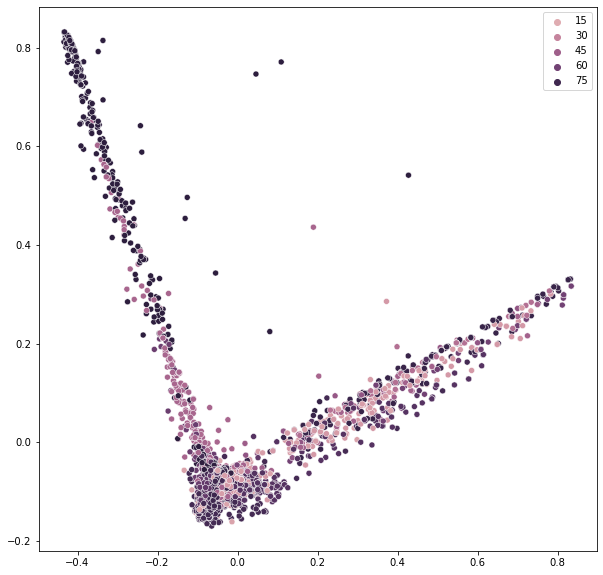

In [13]:

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA

# cc = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', compute_full_tree = True, linkage='average')

# labels = cc.fit_predict(distances)
# print(labels)


pca = PCA(n_components=2)
normalized_vectors = normalize_vectors(vectors_dict[4])
pca_result = np.ascontiguousarray(pca.fit_transform(normalized_vectors))

print(pca.explained_variance_ratio_)


plt.figure(figsize= (10, 10))

sn.scatterplot(x = pca_result[:, 0], y = pca_result[:, 1], hue = clusters_dict[4])


In [16]:
from scipy.cluster.hierarchy import linkage, fclusterdata

# aaa = fclusterdata(normalized_vectors, t = 0.2, criterion='distance', metric=compute_polar_distance)
aaa = fclusterdata(normalized_vectors, t = 2, criterion='maxclust', metric=compute_polar_distance)

# dendrogram(aaa,  p = 8, truncate_mode='level')



<AxesSubplot:>

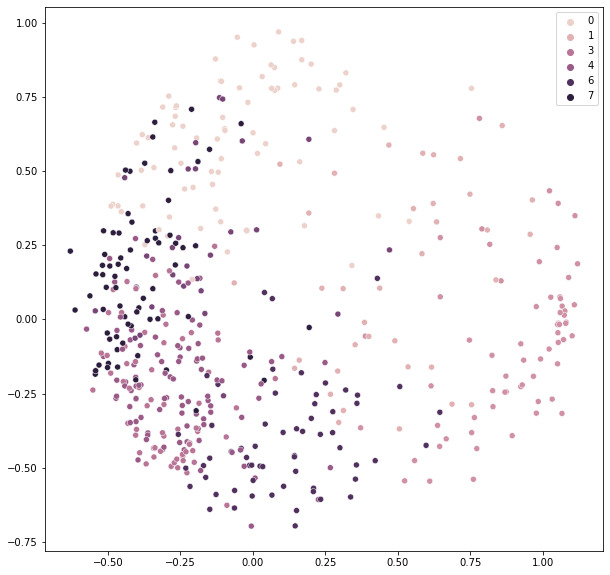

In [99]:

kk = KMeans(n_clusters = 8)

kk_labels = kk.fit_predict(normalized_vectors)

plt.figure(figsize=(10, 10))
sn.scatterplot(x = pca_result[:, 0], y = pca_result[:, 1], hue = kk_labels)






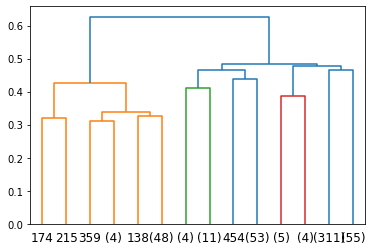

<Figure size 2160x2160 with 0 Axes>

In [12]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(cc, truncate_mode = 'level', p=3)
plt.figure(figsize = (30, 30))
plt.show()

In [13]:
print(np.max(distances), np.min(distances))

print(cc.children_)

0.8374888984730559 0.0
[[208 293]
 [113 465]
 [187 448]
 [354 455]
 [128 500]
 [349 435]
 [ 37 239]
 [ 34 294]
 [188 507]
 [501 506]
 [309 449]
 [369 508]
 [353 511]
 [393 510]
 [348 495]
 [283 381]
 [386 411]
 [504 509]
 [ 65 204]
 [176 298]
 [101 232]
 [252 452]
 [505 517]
 [ 11 515]
 [513 518]
 [  2 514]
 [164 456]
 [ 69 512]
 [412 519]
 [ 61 437]
 [133 285]
 [396 523]
 [525 528]
 [ 76 524]
 [ 36 153]
 [ 87 189]
 [383 529]
 [212 421]
 [182 256]
 [522 527]
 [361 376]
 [ 63 262]
 [312 380]
 [428 458]
 [  6 185]
 [160 397]
 [532 533]
 [109 536]
 [236 282]
 [ 19 534]
 [ 16 391]
 [103 199]
 [ 29 241]
 [152 492]
 [ 26 539]
 [ 96 168]
 [526 541]
 [137 503]
 [538 554]
 [147 521]
 [ 98 148]
 [327 367]
 [502 547]
 [535 540]
 [227 544]
 [ 47  81]
 [ 58 447]
 [462 499]
 [ 54 228]
 [178 387]
 [316 373]
 [ 41 531]
 [516 537]
 [ 46 196]
 [221 366]
 [ 59  77]
 [489 561]
 [410 546]
 [377 543]
 [ 45 555]
 [ 40 372]
 [552 559]
 [121 403]
 [186 238]
 [167 491]
 [169 553]
 [  8 100]
 [520 568]
 [ 73 563

In [58]:
with open('n-gram-divisive.txt', 'w') as f:
  for i in range(SAMPLE_SIZE):
    label_agg = int(labels[i])
    label_scipy = 0 # int(aaa[i])
    label_divisive = str(clusters[i])
    userid = str(sample[i][0])
    group = str(sample[i][1])
    g = group_by_sessions.get_group(sample[i])
    previous_query = g.iloc[0]['Query']
    row = str(label_agg) + ',' + str(label_scipy) + ',' + label_divisive + ',' + '+'.join(sequences[i]) + ',' + userid + ',' + group + ',' + previous_query + '\n'
    f.write(row)
  
  
  

<AxesSubplot:>

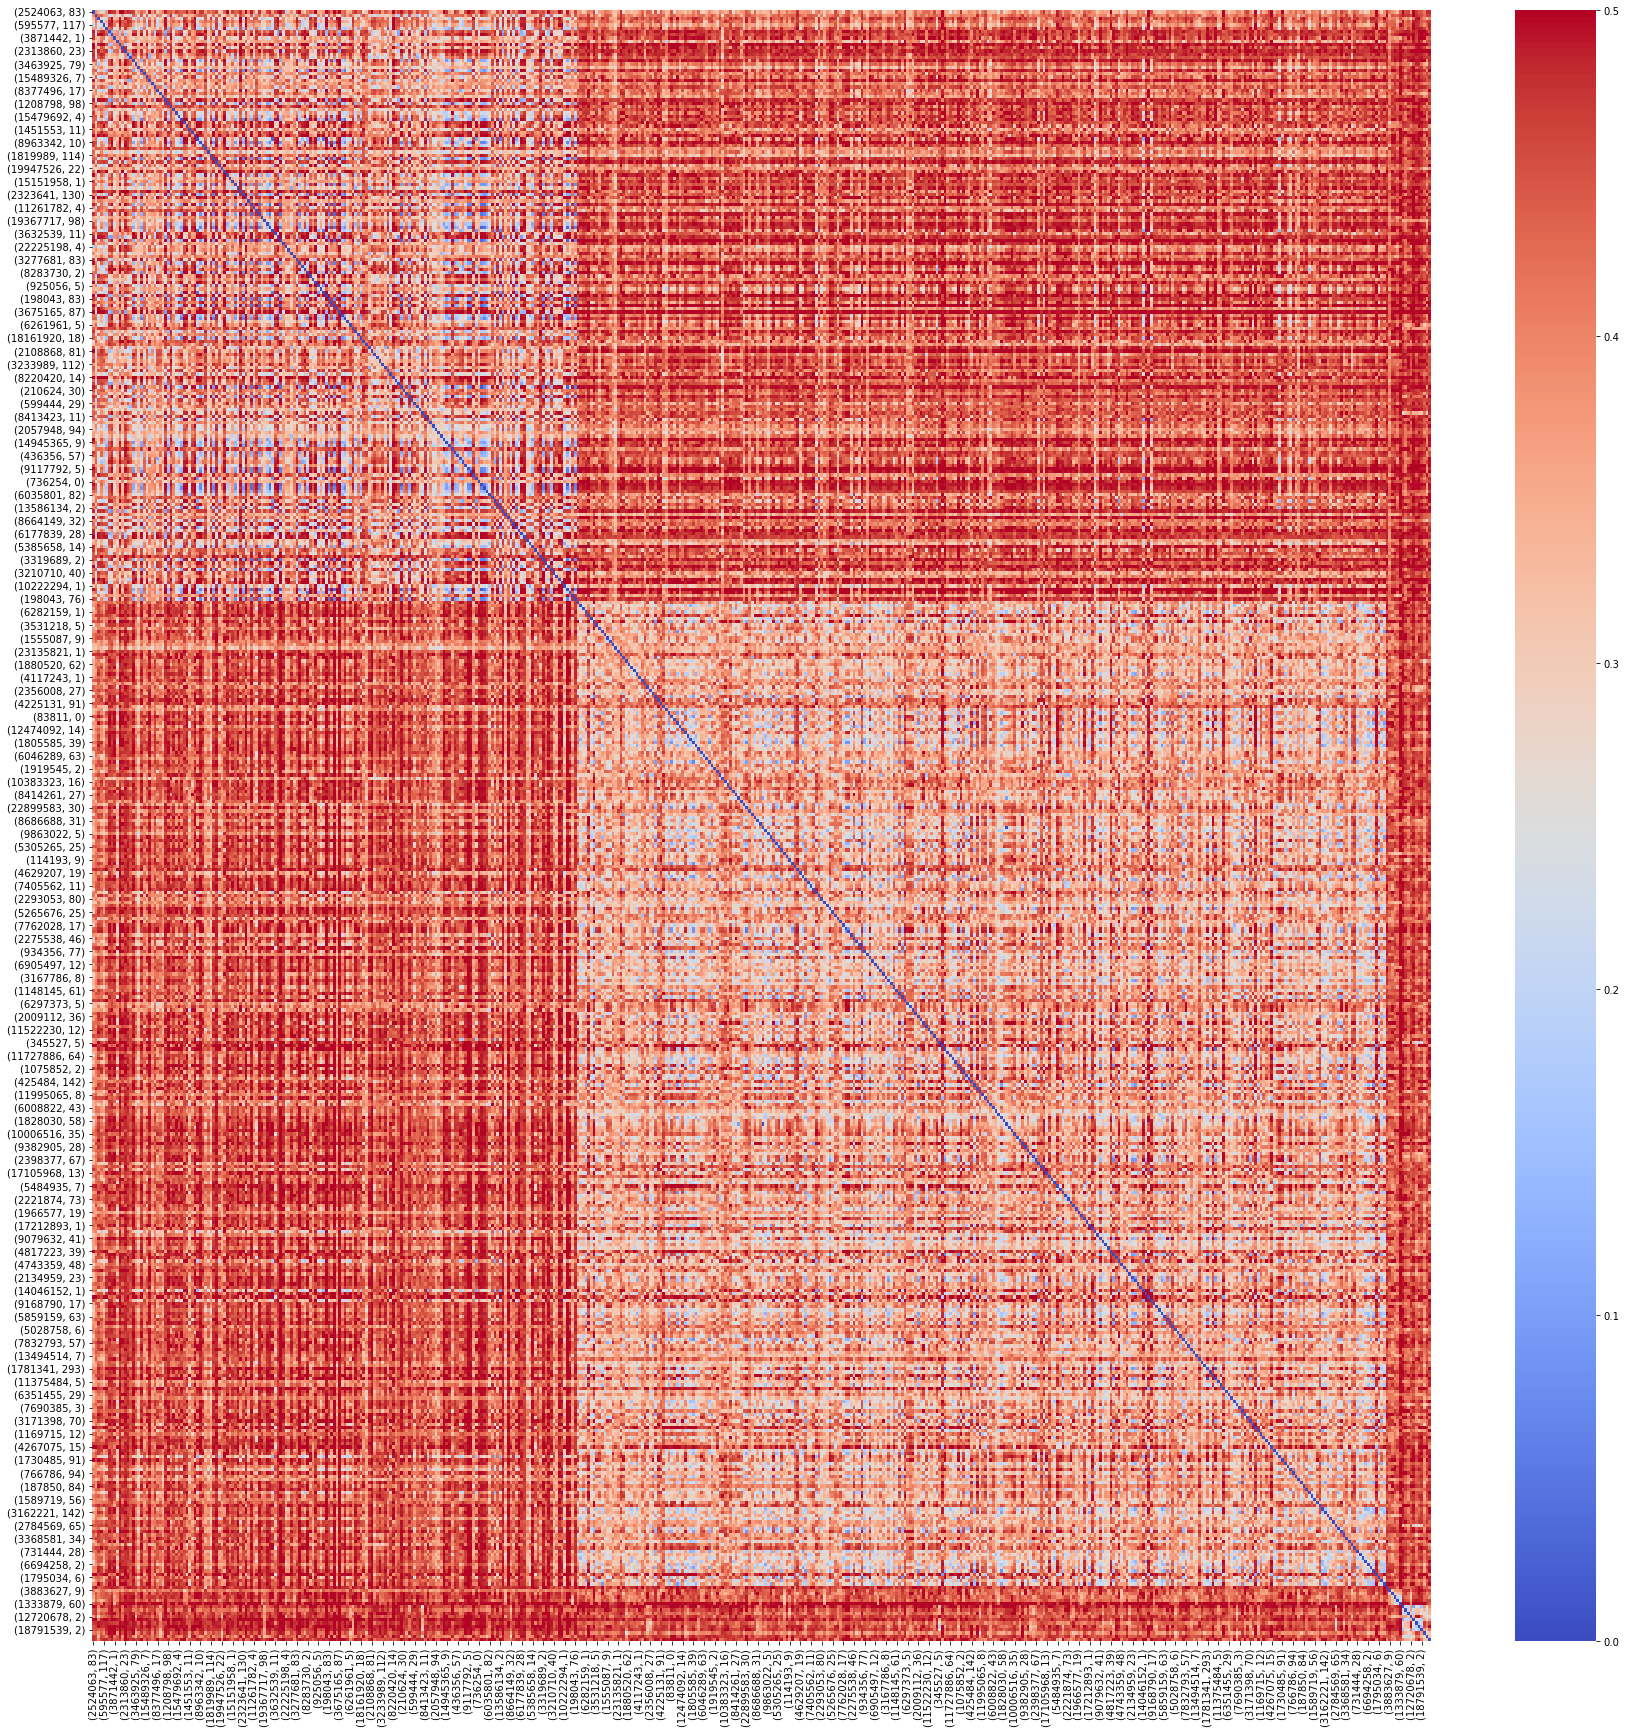

In [81]:
from sklearn.cluster import AgglomerativeClustering

c = AgglomerativeClustering(n_clusters = 5, affinity="precomputed", compute_full_tree = True, linkage="average")

labels = c.fit_predict(distances)

idx = np.argsort(labels)
sorted_sample = [sample[x] for x in idx]

distances_df = pd.DataFrame(data=distances, index=labels, columns = labels).sort_index(axis=0).sort_index(axis=1)
distances_df.set_axis(sorted_sample, axis="index", inplace=True)
distances_df.set_axis(sorted_sample, axis="columns", inplace=True)

plt.figure(figsize= (30, 30))

sn.heatmap(distances_df, cmap="coolwarm")




In [24]:
with open('n-gram-23.txt', 'w') as f:
  for i in range(SAMPLE_SIZE):
    label_divisive = str(clusters_dict[3][i])
    userid = str(sample[i][0])
    group = str(sample[i][1])
    g = group_by_sessions.get_group(sample[i])
    previous_query = g.iloc[0]['Query']
    row = label_divisive + ',' + '+'.join(sequences[i]) + ',' + userid + ',' + group + ',' + previous_query + '\n'
    f.write(row)
  
  

In [23]:
## Trash, scratch cell

# with open('seq.txt', 'w') as f:
#   for idx, sequence in enumerate(sequences):
#     one_letter = {
#       'NewQuery': 'N',
#       'RefinedQuery': 'R',
#       'Click1': 'C',
#       'Click2-5': 'D',
#       'Click6-10': 'E',
#       'Click11+': 'F',
#       'NextPage': 'P'
#     }

#     seq = ''.join([(one_letter[action] + '(1)') for action in sequence])

#     f.write('%d\t%s\n' % (idx + 1, seq))

# with open('n-gram-test-divisive.txt', 'w') as f:
#   for i in range(SAMPLE_SIZE):
#     label_divisive = str(clusters_dict[3][i])
#     userid = str(sample[i][0])
#     group = str(sample[i][1])
#     g = group_by_sessions.get_group(sample[i])
#     previous_query = g.iloc[0]['Query']
#     row = label_divisive + ',' + '+'.join(sequences[i]) + ',' + userid + ',' + group + ',' + previous_query + '\n'
#     f.write(row)

# print([concat_set[i] for i in distinguishing_features])  

# print(concat_set[215])
# print(concat_set[232])

# print(clusters)
# print(distinguishing_features)
# cc = np.asarray(concat_set)
# print(cc[distinguishing_features[30]])

# print(vectors_dict[3][596])

# print(concat_set_dict[3][0])

for key, cluster_info in clusters_info_dict[3].items():
  print("Cluster %d: diameter %f, size %d" % (key, cluster_info["diameter"], cluster_info["cluster_size"]))
  print("Children", cluster_info["children"])
  print("Distinguishing factors")
  print([concat_set_dict[3][idx] for idx in distinguishing_features_dict[3][key]])  

# print(distinguishing_features_dict[4])

Cluster 1: diameter 0.500000, size 5000
Children [2, 3]
Distinguishing factors
[]
Cluster 2: diameter 0.500000, size 1807
Children [6, 7]
Distinguishing factors
[('Click2-5', 'Click2-5'), ('Click2-5', 'Click2-5', 'Click6-10'), ('Click2-5', 'Click2-5', 'Click2-5')]
Cluster 3: diameter 0.500000, size 3193
Children [4, 5]
Distinguishing factors
[]
Cluster 4: diameter 0.500000, size 1727
Children [8, 9]
Distinguishing factors
[('NewQuery', 'Click1'), ('NewQuery', 'NewQuery', 'NewQuery'), ('NextPage', 'NextPage', 'NextPage')]
Cluster 5: diameter 0.500000, size 1466
Children [10, 11]
Distinguishing factors
[]
Cluster 6: diameter 0.500000, size 1018
Children [16, 17]
Distinguishing factors
[('Click2-5', 'Click2-5'), ('Click2-5', 'Click2-5', 'Click6-10'), ('Click2-5', 'Click2-5', 'Click2-5'), ('NewQuery', 'Click2-5'), ('NewQuery', 'Click2-5', 'Click2-5'), ('NextPage', 'Click11+')]
Cluster 7: diameter 0.500000, size 789
Children [28, 29]
Distinguishing factors
[('Click2-5', 'Click2-5'), ('Click